# NYC-Taxi-FHV-Project


In [1]:
import pandas as pd #DataFrame
import numpy as np #For array
import os #for os commands
from math import sin, cos, sqrt, atan2, radians, log #For calculation
import time           #to get the system time
import datetime       #for datetime operations
import holidays       #For extract date time of holidays
import calendar       #For calendar for datetime operations


pd.set_option('display.max_columns', 500)
#os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="E:/GitHub/NYU-Taxi-project/My First Project-b3735f3b3a9d.json"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./My Project 14295-223aab171173.json"
from google.cloud import bigquery
client = bigquery.Client()

#For geospatial data
import geopandas as gpd   #For geospatial data
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import Polygon
import geohash_hilbert as ghh # For geohash code
import choroplethNYC as cp #For taxi zone map

#For machine learning models
import sklearn
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge #For lasso and ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#For visualization purpose
from scipy.misc import imread, imresize, imsave 
from pandas.plotting import scatter_matrix
import scipy         #for other dependancies
import seaborn as sns #for making plots
from scipy.misc import imread, imresize, imsave  
from bokeh.palettes import Spectral4
from bokeh.plotting import figure, output_notebook, show
from IPython.display import HTML
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
from scipy.misc import imread, imresize, imsave  
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn')

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data Preprocessing
### Query Data from BigQuery

In [2]:
start = time.time()
query = (
"""
SELECT travel_time, date_of_year, month_of_year, day_of_year, pickup_hour,
    dropoff_datetime,pickup_datetime,
    pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,
    temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
FROM
(
      SELECT *,ROW_NUMBER() OVER(partition by date_of_year, pickup_hour) as row_number
      FROM
      (
            SELECT pickup_datetime, dropoff_datetime, pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude,
            EXTRACT (HOUR FROM pickup_datetime) as pickup_hour,
            EXTRACT (DAY FROM pickup_datetime) as day_of_year,
            EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
            EXTRACT (DATE FROM pickup_datetime) as date_of_year,
            TIMESTAMP_DIFF(TIMESTAMP(dropoff_datetime), TIMESTAMP(pickup_datetime), SECOND) as travel_time,
            passenger_count
            FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
            WHERE pickup_latitude IS NOT NULL AND pickup_longitude IS NOT NULL and
                dropoff_longitude IS NOT NULL and dropoff_latitude IS NOT NULL
      ) x
) x
JOIN
(
 select cast(mo as int64) as month,cast(da as int64) as day,temp,visib,mxpsd,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
 from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
) y on x.month_of_year = y.month and x.day_of_year = y.day
where x.row_number <= 200
"""
)
data=pd.io.gbq.read_gbq(query,dialect='standard')
end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Time taken by above cell is 3.9018571972846985.


## Optimize the memory usage

In [3]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

# Convert object to int
obj = data.select_dtypes(include = 'object')
obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert int64 to int8
obj = data.select_dtypes(include = 'int64')
obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

# Convert float64 to float32
obj = data.select_dtypes(include = 'float64')
obj_f = obj.apply(pd.to_numeric, downcast='float')

# Calculated the memory we reduced by down grade int and float
print("Original memory usage: ", get_usage(data))
data[obj_f32.columns] = obj_f32
data[obj_int.columns] = obj_int
data[obj_f.columns] = obj_f
print("After converting int and float memory usage: ", get_usage(data))

Original memory usage:  507.15 MB
After converting int and float memory usage:  90.54 MB


## Exploratory Data Analysis & Process

### Data Cleaning : Location

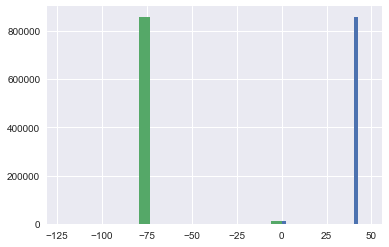

In [4]:
data['pickup_latitude'].hist(bins=20)
data['pickup_longitude'].hist(bins=20)

# remove any pickup not in the manha
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
data = data[(data.pickup_longitude> xlim[0]) & (data.pickup_longitude < xlim[1])]
data = data[(data.dropoff_longitude> xlim[0]) & (data.dropoff_longitude < xlim[1])]
data = data[(data.pickup_latitude> ylim[0]) & (data.pickup_latitude < ylim[1])]
data = data[(data.dropoff_latitude> ylim[0]) & (data.dropoff_latitude < ylim[1])]

### Distance: Haversine and Manhattan distance

In [5]:
def haversine_(lat1, lng1, lat2, lng2):
    """calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b
data['haversine_distance'] = round(haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)
data['manhattan_distance'] = round(manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

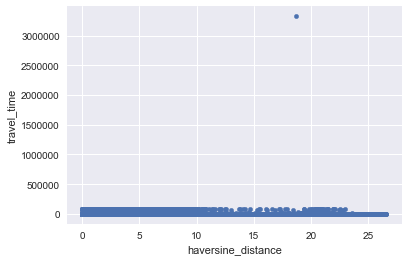

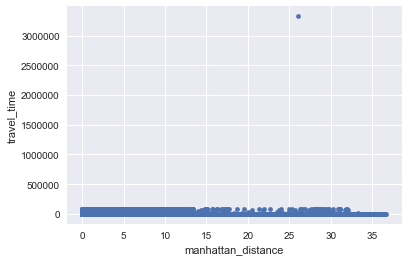

In [6]:
data.plot(x='haversine_distance',y='travel_time',kind='scatter')
data.plot(x='manhattan_distance',y='travel_time',kind='scatter')

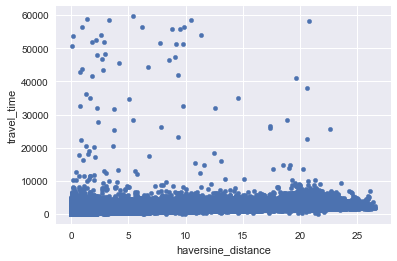

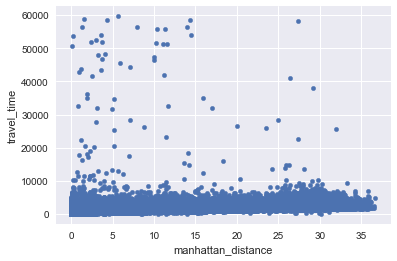

In [7]:
data = data.loc[(data['haversine_distance']>0) & (data['haversine_distance']<50)  &  (data['travel_time'] > 0) & (data['travel_time'] < 60000) ]
data.plot(x='haversine_distance',y='travel_time',kind='scatter')
data.plot(x='manhattan_distance',y='travel_time',kind='scatter')

### Trip Duration vs Hours, Day of Week and Month

In [8]:
# create weekday
data["weekday"] = data['pickup_datetime'].dt.dayofweek

# create travel time
data['travel_time'] = round(data['travel_time'], 2)

#create holiday
us_holidays = holidays.UnitedStates()
data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)

#### Hourly Duration

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


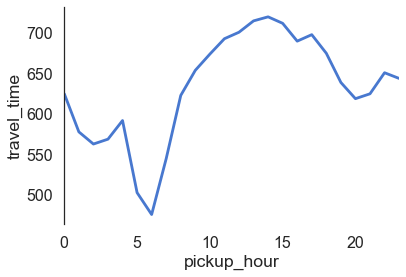

In [9]:
summary_hour_duration = pd.DataFrame(data.groupby('pickup_hour')['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", value="travel_time")
sns.despine(bottom = True)

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


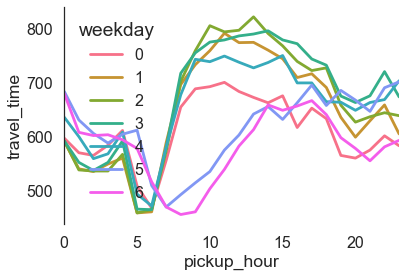

In [10]:
summary_hour_duration = pd.DataFrame(data.groupby(['weekday','pickup_hour'])['travel_time'].median())
summary_hour_duration.reset_index(inplace = True)
summary_hour_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_hour_duration, time="pickup_hour", unit = "unit", condition="weekday", value="travel_time")
sns.despine(bottom = True)

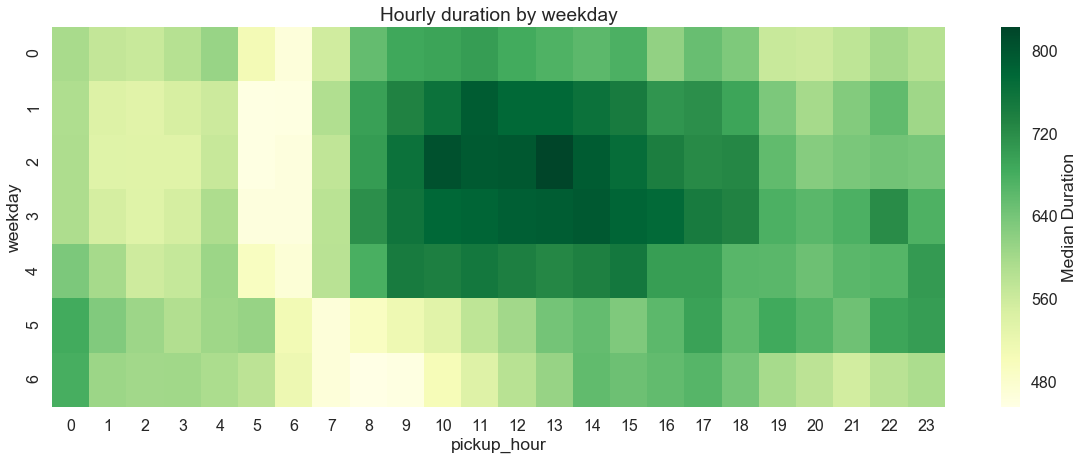

In [11]:
heatmap_data1 = summary_hour_duration.pivot(index = 'weekday',columns = 'pickup_hour',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
sns.heatmap(heatmap_data1, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

59657


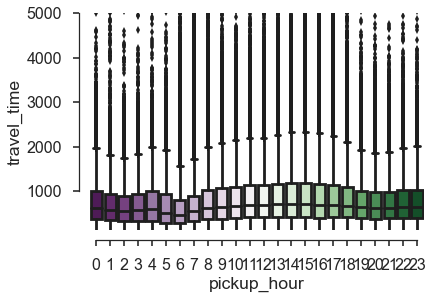

In [12]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="pickup_hour", y="travel_time", data=data, palette="PRGn")
plt.ylim(120, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

####  Weekly Durations

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


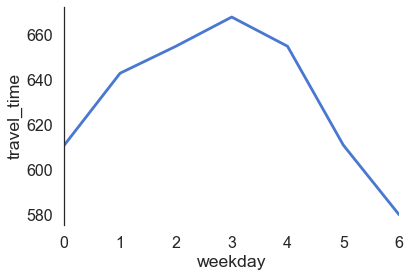

In [13]:
summary_week_duration = pd.DataFrame(data.groupby(['weekday'])['travel_time'].median())
summary_week_duration.reset_index(inplace = True)
summary_week_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_week_duration, time="weekday", unit = "unit", value="travel_time")
sns.despine(bottom = True)

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


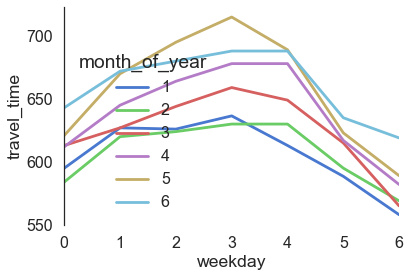

In [14]:
summary_weekday_duration = pd.DataFrame(data.groupby(['weekday','month_of_year'])['travel_time'].median())
summary_weekday_duration.reset_index(inplace = True)
summary_weekday_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_weekday_duration, time="weekday", unit = "unit", condition="month_of_year", value="travel_time")
sns.despine(bottom = True)

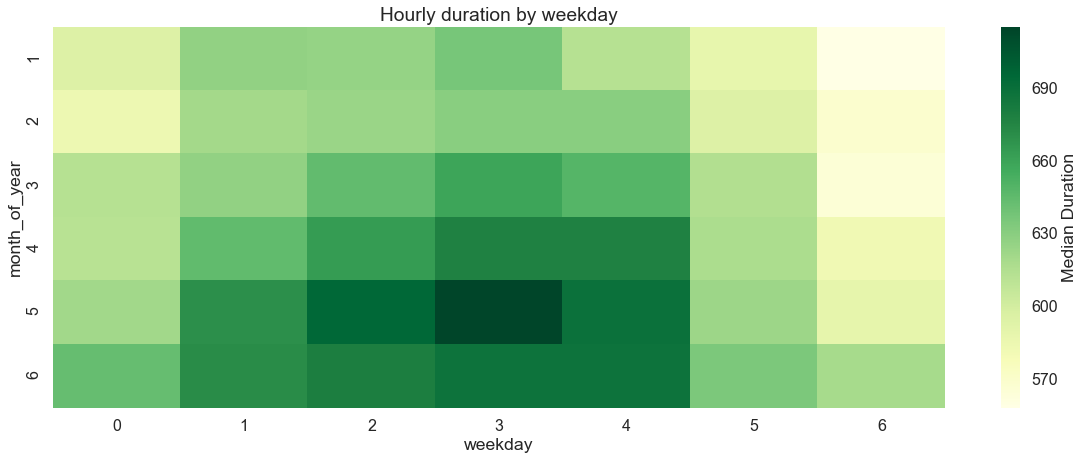

In [15]:
heatmap_data2 = summary_weekday_duration.pivot(index = 'month_of_year',columns = 'weekday',values = 'travel_time')
fig,ax=plt.subplots(figsize = (20,7))
plt.title('Hourly duration by weekday')
ax.axis
sns.heatmap(heatmap_data2, cbar_kws={'label': 'Median Duration'}, cmap="YlGn")

59657


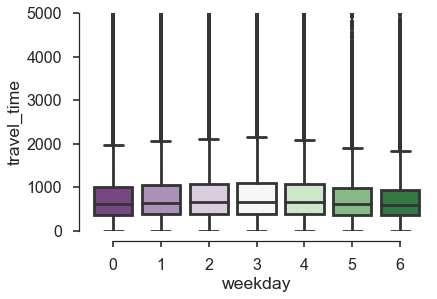

In [16]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="weekday", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

#### Monthly Duration

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


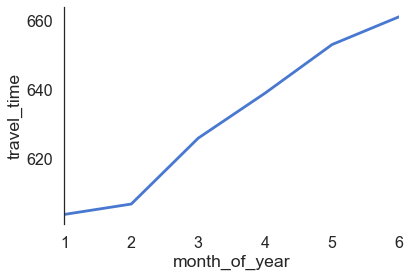

In [17]:
summary_month_duration = pd.DataFrame(data.groupby(['month_of_year'])['travel_time'].median())
summary_month_duration.reset_index(inplace = True)
summary_month_duration['unit']=1
sns.set(style="white", palette="muted", color_codes=False)
sns.set_context("poster")
sns.tsplot(data=summary_month_duration, time="month_of_year", unit = "unit", value="travel_time")
sns.despine(bottom = True)

59657


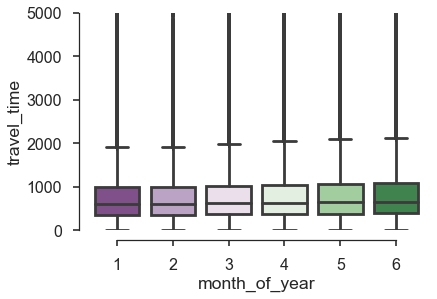

In [18]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="month_of_year", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

### Passenger count

59657


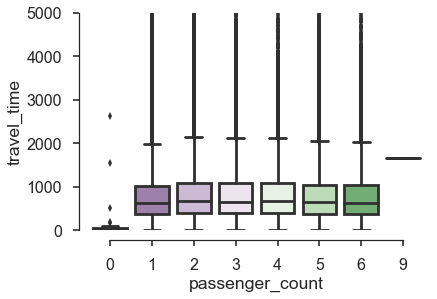

In [19]:
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(x="passenger_count", y="travel_time", data=data, palette="PRGn")
plt.ylim(0, 5000)
sns.despine(offset=10, trim=True)
print(data.travel_time.max())

### Data Cleaning: Weather

In [20]:
# refill visib using forward or backward
data['visib'] = data['visib'].replace(999.9, np.nan).fillna(method='ffill')

# refill mxpsd using forward or backward
data['mxpsd'] = data['mxpsd'].replace(999.9, np.nan).fillna(method='ffill')              

# refill wdsp using forward or backward
data['wdsp'] = data['wdsp'].replace(999.9, np.nan).fillna(method='ffill')              

# refill gust as 0
data.loc[(data['gust'] == 999.9), 'gust'] = 0

# refit sndp as 0
data.loc[data['sndp'] == 999.9, 'sndp'] = 0

### Summary of Weather Data

In [21]:
df_weather = pd.read_csv("weather_2016_cleaned.csv")

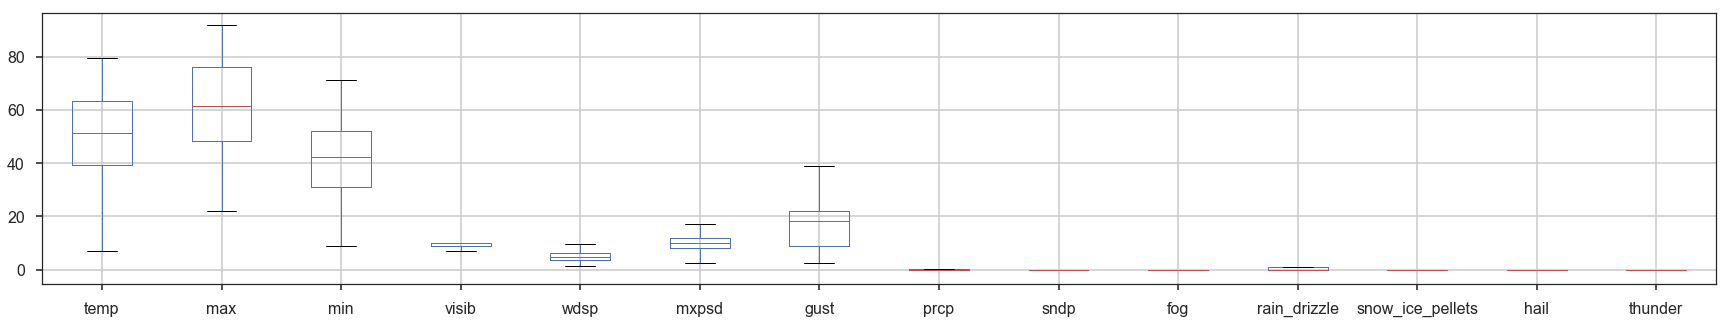

In [22]:
df_weather.boxplot(figsize=(30,5))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a332b8278>,
      dtype=object)

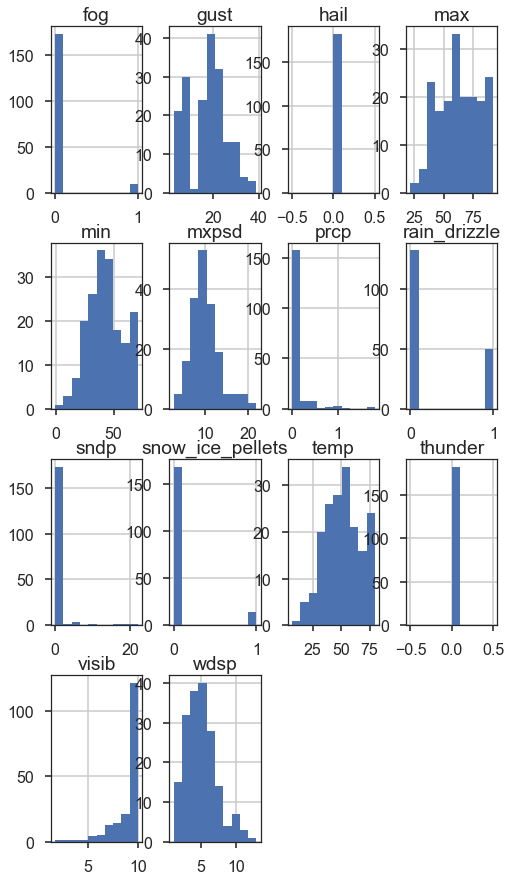

In [23]:
df_weather.hist(figsize=(8,15))

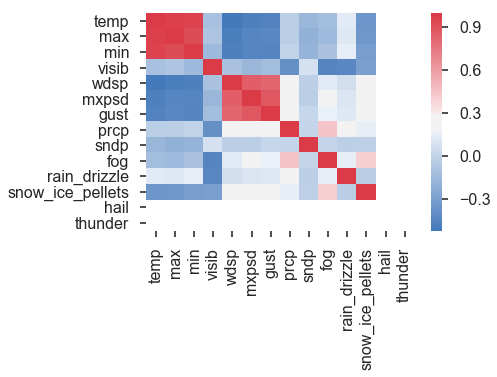

In [24]:
corr = df_weather.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

### Weather vs Trip Duration

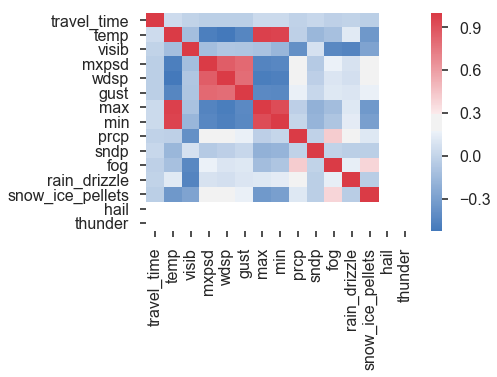

In [25]:
df = data[['date_of_year','travel_time', 'temp','visib','mxpsd', 'wdsp', 'gust', 'max', 'min', 'prcp', 'sndp', 
             'fog', 'rain_drizzle', 'snow_ice_pellets', 'hail', 'thunder']]
corr = df.corr()
cmap = sns.diverging_palette(250, 10, sep=20, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=cmap)

## Feature Engineer

### Transformation of Trip Duration

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


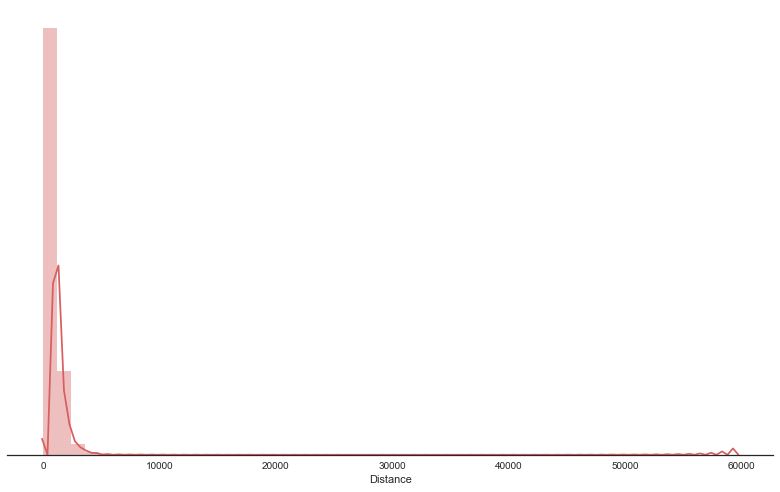

In [28]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(data['travel_time'].values+1, axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

### Log(Trip Duration)

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


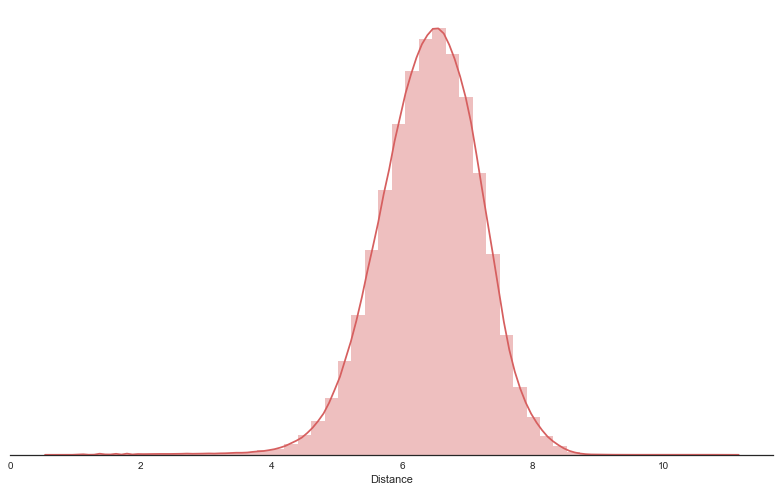

In [29]:
sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(data['travel_time'].values+1), axlabel = 'Distance', label = 'Histogrqm of Distance', bins = 50, color="r")
plt.setp(axes, yticks=[])
plt.tight_layout()

### Create Dummy

In [30]:
data_month = pd.get_dummies(data['month_of_year'])
data_month.columns = ['month_' + str(col) for col in data_month.columns]

data_hour = pd.get_dummies(data['pickup_hour'])
data_hour.columns = ['hour_' + str(col) for col in data_hour.columns]

data_day = pd.get_dummies(data['day_of_year'])
data_day.columns = ['day_' + str(col) for col in data_day.columns]

# 0 for Monday
data_week = pd.get_dummies(data['weekday'])
data_week.columns = ['week_' + str(col) for col in data_week.columns]

data = pd.concat([data, data_month, data_week, data_day, data_hour], axis=1)

### Bearing

In [31]:
def bearing_array(lat1, lng1, lat2, lng2):
    """calculate bearing for each trip"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
data['bearing'] = round(bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude),3)

## K-means Cluster
#### Cluster pickup and dropoff locations¶

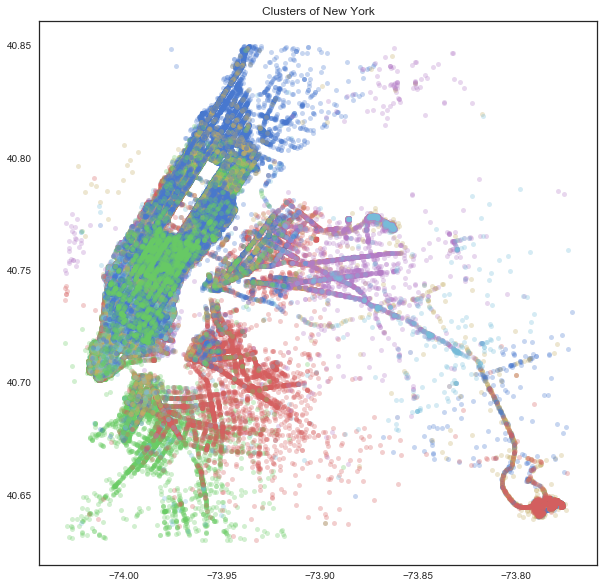

In [32]:
loc_df = pd.DataFrame()
loc_df['longitude'] = data.pickup_longitude
loc_df['latitude'] = data.pickup_latitude
loc_df["dropoff_lat"] = data.dropoff_latitude
loc_df['dropoff_long'] = data.dropoff_longitude

kmeans = KMeans(n_clusters=50, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
plt.figure(figsize = (10,10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.3, markersize = 10)

plt.title('Clusters of New York')
plt.show()

In [33]:
data['cluster'] = loc_df.label

### Geohash

#### Add geohash to represent location

In [34]:
pickup = []
dropoff = []
for i in range(len(data)):
    
    dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))


data['dropoff_geo'] = dropoff
data["dropoff_geo_recode"] = data["dropoff_geo"].astype('category').cat.codes

#### Plot geohash map

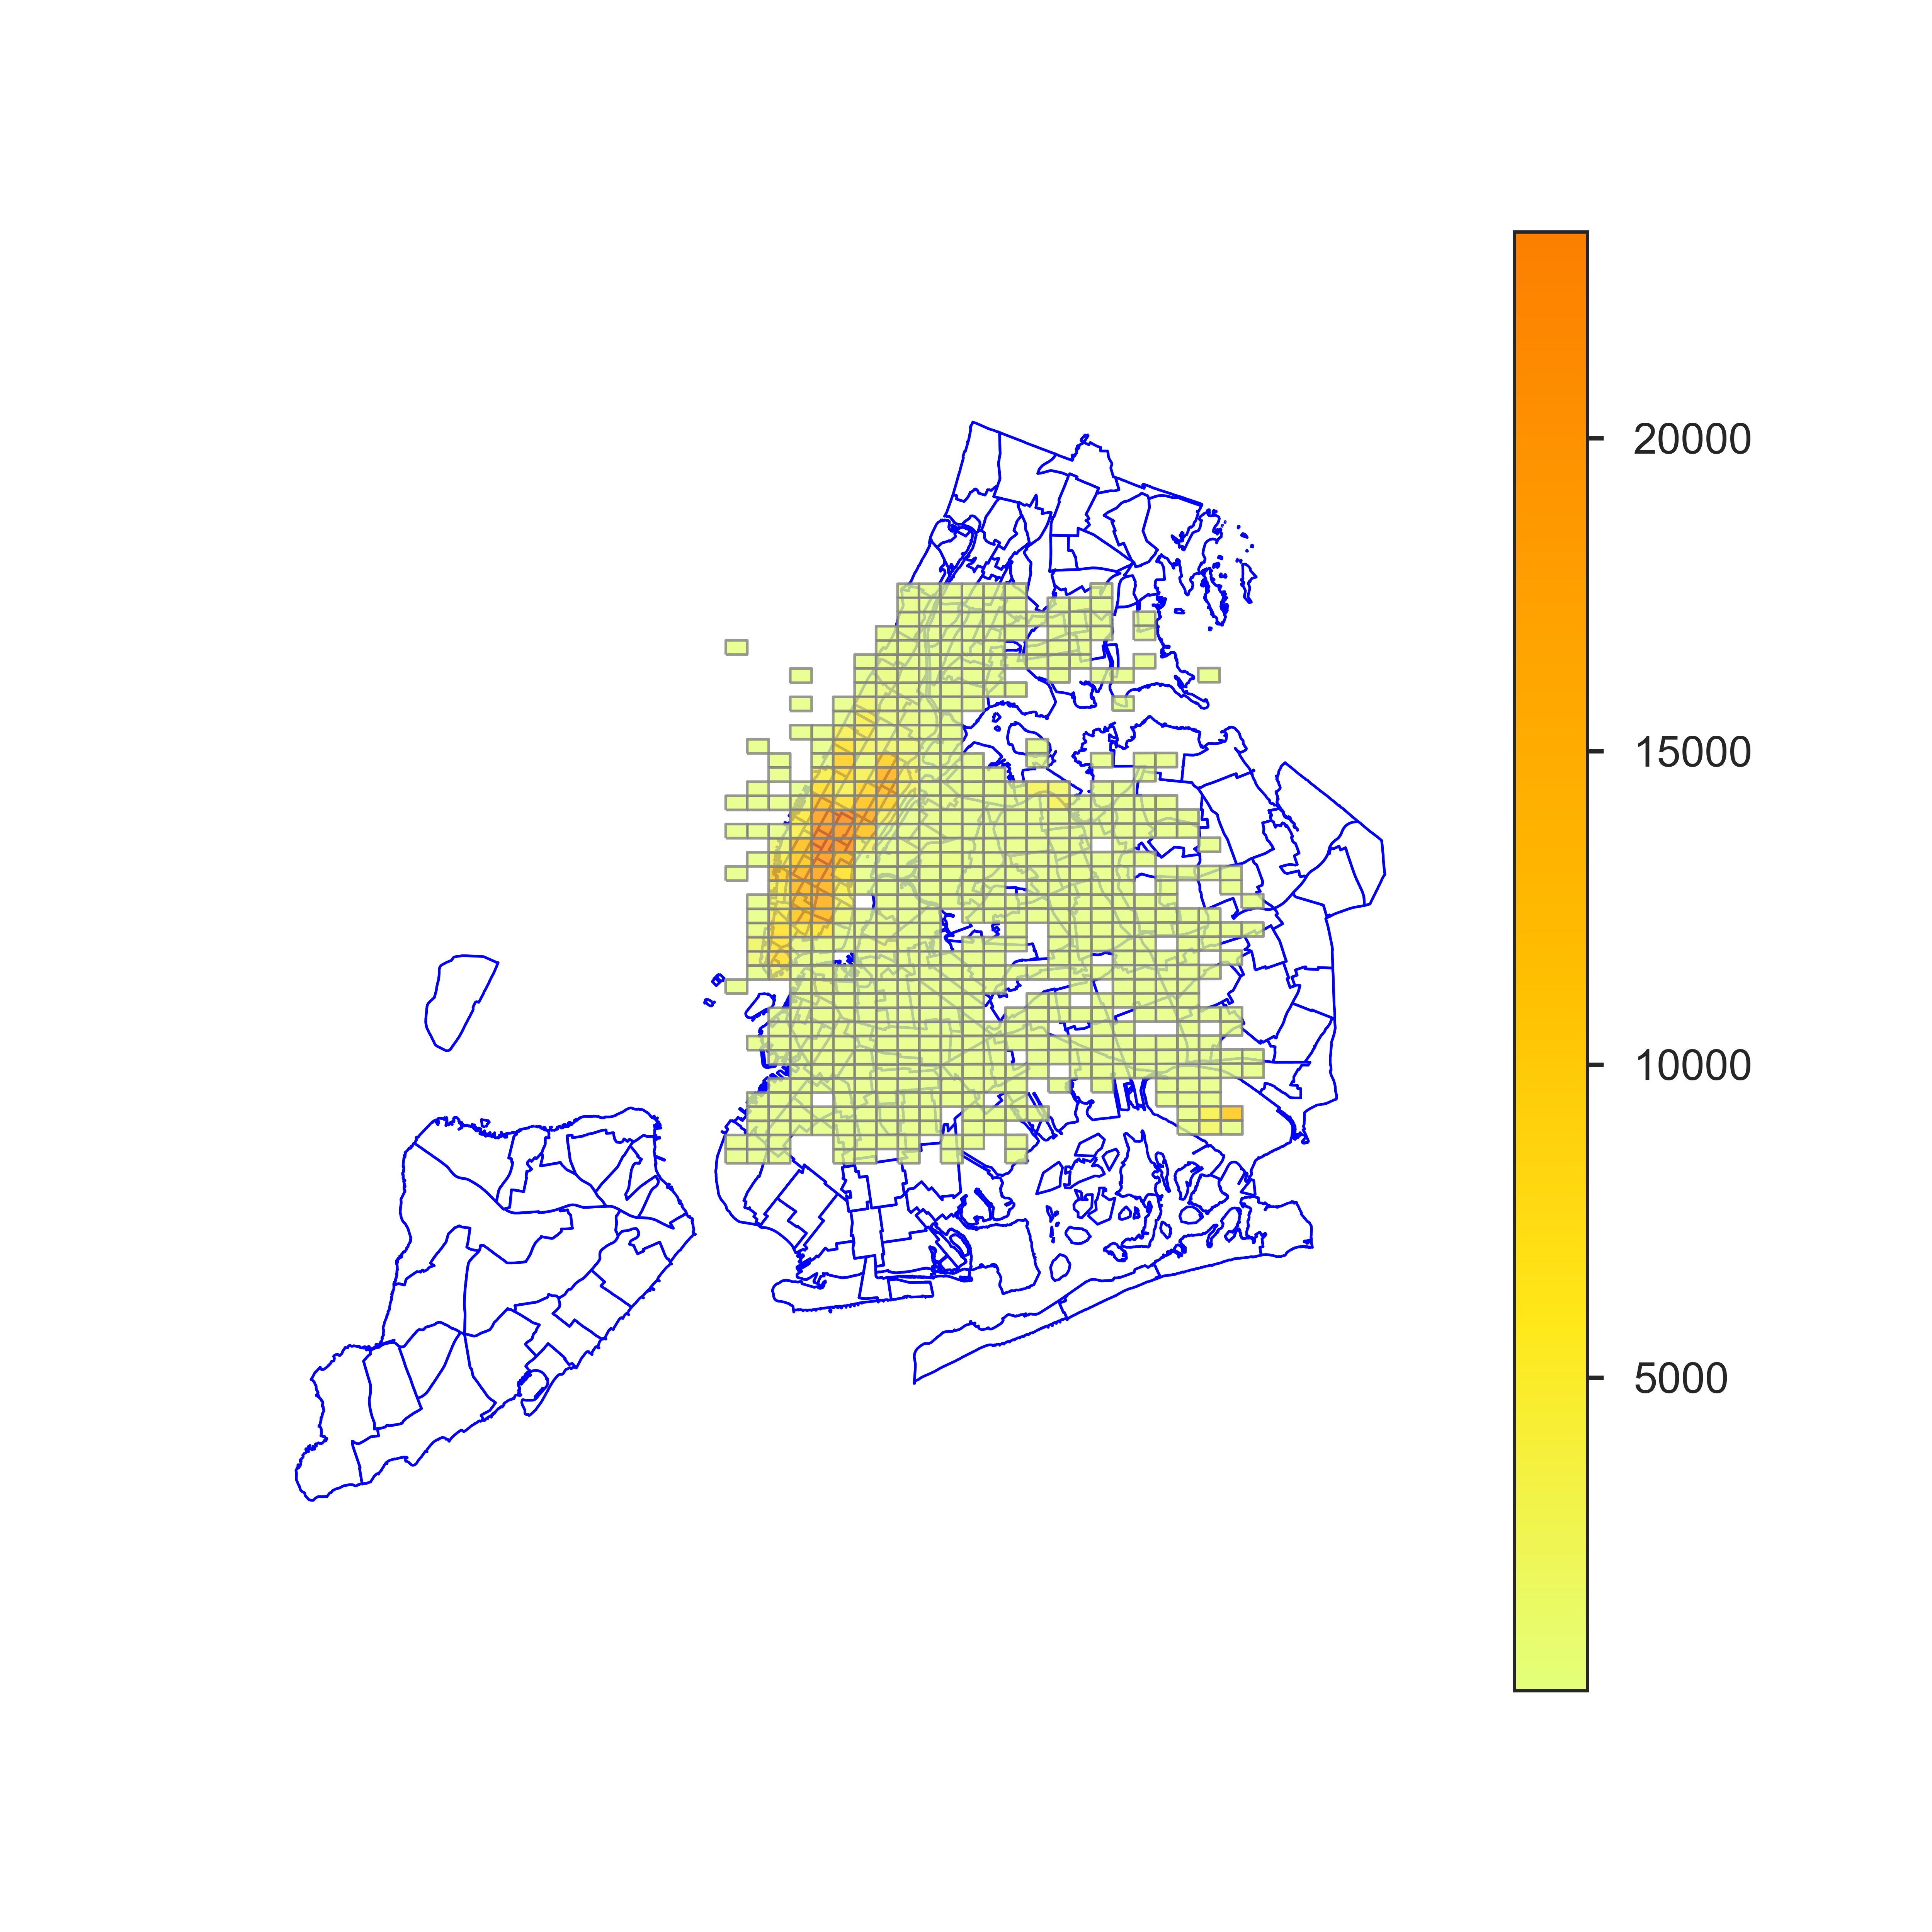

In [35]:
from IPython.display import Image
Image(filename='geohash_pickup.png', width=500, height=300)

## Modeling

In [36]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'cluster',
       'dropoff_latitude', 'passenger_count',  'dropoff_geo_recode', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'manhattan_distance','haversine_distance']

x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

In [37]:
def train_test_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    print(clf)
    # Make prediction on the training data
    y_train_pred = clf.predict(x_train)

    # Make predictions on test data
    y_test_pred = clf.predict(x_test)
    
    # Evaluate
    R2_Train = clf.score(x_train,y_train)
    R2_Test = clf.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
#     RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
#     RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE']
    metric_values_train = [R2_Train, RMSE_Train]
    metric_values_test = [R2_Test, RMSE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [38]:
def cv_model_performance(clf, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test):
    
    # Fit a model by providing X and y from training set
    clf.fit(x_train, y_train)
    model = clf.best_estimator_
    print(model)
    
    # Make prediction on the training data
    y_train_pred = model.predict(x_train)

    # Make predictions on test data
    y_test_pred = model.predict(x_test)
    
    # Evaluate
    R2_Train = model.score(x_train,y_train)
    R2_Test = model.score(x_test,y_test)
    RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
    RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))
    RMSLE_Train = sqrt(mean_squared_log_error(y_train, y_train_pred))
    RMSLE_Test = sqrt(mean_squared_log_error(y_test, y_test_pred))
    
    metric_names = ['R2','RMSE','RMSLE']
    metric_values_train = [R2_Train, RMSE_Train, RMSLE_Train]
    metric_values_test = [R2_Test, RMSE_Test, RMSLE_Test]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [39]:
df = data.copy()

### Random Forest

#### Spliting Train and Test Data

In [40]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'cluster',
       'dropoff_latitude', 'passenger_count',  'dropoff_geo_recode', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'manhattan_distance','haversine_distance']

x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

#### Cross Validation

In [129]:
start = time.time()

# Choose the type of classifier. 
rf = RandomForestRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [300,400], 
              'max_features': ['auto'], 
              'max_depth': [25,35], 
              'min_samples_split': [20,40],
              'n_jobs':[-1]
             }

# read theory
grid_obj = GridSearchCV(rf, param_grid, cv=3, n_jobs = 8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=25, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1 
[CV] max_depth=25, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1 
[CV] max_depth=25, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1 
[CV] max_depth=25, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1 
[CV] max_depth=25, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1 
[CV] max_depth=25, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1 
[CV] max_depth=25, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1 
[CV] max_depth=25, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1 
[CV]  max_depth=25, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1, score=0.7808085865580237, total= 3.1min
[CV] max_depth=25, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1 
[CV]  max

[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:  3.2min


[CV]  max_depth=25, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1, score=0.7842537180257504, total= 3.3min
[CV] max_depth=25, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1 
[CV]  max_depth=25, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1, score=0.7863139022920995, total= 3.3min
[CV] max_depth=25, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1 
[CV]  max_depth=25, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1, score=0.7866045471018944, total= 3.3min
[CV] max_depth=35, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1 
[CV]  max_depth=25, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1, score=0.78428933729799, total= 4.5min
[CV] max_depth=35, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1 
[CV]  max_depth=25, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1, score=0.7862926436151958, total= 4.5

[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:  6.3min


[CV]  max_depth=35, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1, score=0.7839139572286125, total= 3.4min
[CV] max_depth=35, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1 
[CV]  max_depth=25, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1, score=0.7806457791857757, total= 4.2min
[CV] max_depth=35, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1 
[CV]  max_depth=25, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1, score=0.7827107324233655, total= 4.2min
[CV] max_depth=35, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1 


[Parallel(n_jobs=8)]: Done  12 out of  24 | elapsed:  7.6min remaining:  7.6min


[CV]  max_depth=25, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1, score=0.7831650397008496, total= 4.2min
[CV] max_depth=35, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1 
[CV]  max_depth=35, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1, score=0.7867779181617381, total= 3.4min
[CV] max_depth=35, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1 
[CV]  max_depth=35, max_features=auto, min_samples_split=20, n_estimators=300, n_jobs=-1, score=0.7861615559729112, total= 3.3min
[CV] max_depth=35, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1 


[Parallel(n_jobs=8)]: Done  15 out of  24 | elapsed:  8.0min remaining:  4.8min


[CV]  max_depth=35, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1, score=0.7841720821428062, total= 4.5min
[CV] max_depth=35, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1 
[CV]  max_depth=35, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1, score=0.7807710678931553, total= 3.1min
[CV]  max_depth=35, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1, score=0.7832949829047151, total= 3.1min


[Parallel(n_jobs=8)]: Done  18 out of  24 | elapsed: 10.8min remaining:  3.6min


[CV]  max_depth=35, max_features=auto, min_samples_split=40, n_estimators=300, n_jobs=-1, score=0.7827515497377866, total= 3.1min
[CV]  max_depth=35, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1, score=0.7869164083701411, total= 4.5min
[CV]  max_depth=35, max_features=auto, min_samples_split=20, n_estimators=400, n_jobs=-1, score=0.7862193416453347, total= 4.2min


[Parallel(n_jobs=8)]: Done  21 out of  24 | elapsed: 11.1min remaining:  1.6min


[CV]  max_depth=35, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1, score=0.7808809043014334, total= 3.3min
[CV]  max_depth=35, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1, score=0.7832721630581732, total= 3.3min
[CV]  max_depth=35, max_features=auto, min_samples_split=40, n_estimators=400, n_jobs=-1, score=0.7829890894839862, total= 2.3min


[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed: 11.5min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  24 out of  24 | elapsed: 11.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.904415  0.789811
RMSE     0.216486  0.319824
RMSLE    0.029667  0.043949
Time taken by above cell is 12.494407665729522.


#### Train RF

In [41]:
start = time.time()
parameters = {'n_estimators': 350,
             'max_features': 'auto',
              'max_depth': 35,
              'min_samples_split': 20,
              'random_state': 2,
              'n_jobs': -1
              }
rf = RandomForestRegressor(**parameters)
train_test_model_performance(rf)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=35,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=-1,
           oob_score=False, random_state=2, verbose=0, warm_start=False)
            train      test
metrics                    
R2       0.908998  0.803543
RMSE     0.234418  0.343083
Time taken by above cell is 7.919380966822306.


#### Feature Importance

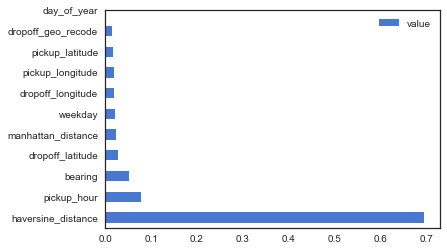

In [42]:
features = pd.DataFrame(list(zip(selected_features, rf.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Gradient Boosting Trees

#### Cross Validation

In [ ]:
start = time.time()
GBDT = GradientBoostingRegressor()

# Choose some parameter combinations to try
param_grid = {'n_estimators': [120, 150], 
              'max_depth': [3, 5], 
              'learning_rate': [0.2],
              'min_samples_split': [20,40],
              'max_features': [0.5,0.7],
              'subsample':[0.5,0.7],
             }

# read theory
grid_obj = GridSearchCV(GBDT, param_grid, cv=3, n_jobs=8, iid=False, verbose=10, scoring='r2')
cv_model_performance(grid_obj)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

#### Train GBDT

In [43]:
start = time.time()

# Choose some parameter combinations to try
parameters = {
    'n_estimators': 150,
    'max_depth': 6,
    'learning_rate': 0.2,
    'min_samples_split': 30,
    'max_features': 'sqrt',
    'subsample': 0.7,
    'random_state': 2
}

GBDT = GradientBoostingRegressor(**parameters)
train_test_model_performance(GBDT)

end = time.time()
print("Time taken by above cell is {}.".format((end-start)/60))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.2, loss='ls', max_depth=6,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=30,
             min_weight_fraction_leaf=0.0, n_estimators=150,
             presort='auto', random_state=2, subsample=0.7, verbose=0,
             warm_start=False)
            train      test
metrics                    
R2       0.813138  0.795512
RMSE     0.335913  0.350025
Time taken by above cell is 2.1175339539845783.


#### Feature Improtance

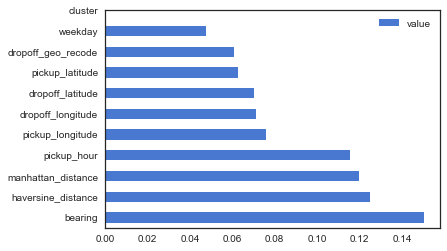

In [45]:
features = pd.DataFrame(list(zip(selected_features, GBDT.feature_importances_))).sort_values(by=[1], ascending=False)
features.columns = ['feature', 'value']
features.head(10)

ax = features.iloc[0:10].plot.barh()
t = np.arange(11)
ax.set_yticks(t)
ax.set_yticklabels(features['feature'])
plt.show()

### Extremely Gradient Boosting (XGB)

#### Spliting Train and Test Data

In [46]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
      'dropoff_latitude', 'passenger_count',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 
                     'haversine_distance','cluster','bearing','manhattan_distance']
x = data[selected_features]
y = np.log(data['travel_time'])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


In [47]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dvalid = xgb.DMatrix(x_test, label=y_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


#### Grid Search CV for parameter selection

In [47]:
from sklearn.grid_search import GridSearchCV 

parameters_for_testing = {
   'min_child_weight':[10,15],
   'max_depth':[10],
   'alpha':[5],
    'lambda':[1]
    
}
          
xgb_model = xgb.XGBRegressor(learning_rate =0.1, n_estimators=100, max_depth=5,
    min_child_weight=1, gamma=0, subsample=0.7, colsample_bytree=0.7, nthread= 8, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, cv=3, n_jobs=8,iid=False, verbose=10,scoring='r2')
gsearch1.fit(x_train,y_train)
print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] alpha=5, lambda=1, max_depth=10, min_child_weight=10 ............


/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] alpha=5, lambda=1, max_depth=10, min_child_weight=10 ............
[CV] alpha=5, lambda=1, max_depth=10, min_child_weight=10 ............


/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] alpha=5, lambda=1, max_depth=10, min_child_weight=15 ............
[CV] alpha=5, lambda=1, max_depth=10, min_child_weight=15 ............


/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV] alpha=5, lambda=1, max_depth=10, min_child_weight=15 ............


/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[CV]  alpha=5, lambda=1, max_depth=10, min_child_weight=15, score=0.807363 -  18.8s
[CV]  alpha=5, lambda=1, max_depth=10, min_child_weight=15, score=0.808350 -  18.8s


[Parallel(n_jobs=8)]: Done   2 out of   6 | elapsed:   19.0s remaining:   38.1s


[CV]  alpha=5, lambda=1, max_depth=10, min_child_weight=10, score=0.807184 -  19.2s


[Parallel(n_jobs=8)]: Done   3 out of   6 | elapsed:   19.3s remaining:   19.3s


[CV]  alpha=5, lambda=1, max_depth=10, min_child_weight=15, score=0.803608 -  19.2s
[CV]  alpha=5, lambda=1, max_depth=10, min_child_weight=10, score=0.806613 -  19.4s
[CV]  alpha=5, lambda=1, max_depth=10, min_child_weight=10, score=0.803667 -  19.5s


[Parallel(n_jobs=8)]: Done   4 out of   6 | elapsed:   19.5s remaining:    9.8s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   19.6s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   19.7s finished
/Users/franceszhang/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[mean: 0.80582, std: 0.00154, params: {'alpha': 5, 'lambda': 1, 'max_depth': 10, 'min_child_weight': 10}, mean: 0.80644, std: 0.00204, params: {'alpha': 5, 'lambda': 1, 'max_depth': 10, 'min_child_weight': 15}]
best params
{'alpha': 5, 'lambda': 1, 'max_depth': 10, 'min_child_weight': 15}
best score
0.8064400595306417


#### Train model 

In [48]:
xgb_pars = {'min_child_weight': 10, 'eta': 0.1, 'colsample_bytree': 0.7, 
            'max_depth': 15, 'alpha' : 8,
             'subsample': 0.7,'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
'eval_metric': 'rmse', 'objective': 'reg:linear','lambda':1}
model = xgb.train(xgb_pars, dtrain, 150, watchlist, early_stopping_rounds=2,
      maximize=False, verbose_eval=1)
print('Modeling RMSE %.5f' % model.best_score)

[0]	train-rmse:5.36817	valid-rmse:5.36681
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:4.83506	valid-rmse:4.83377
[2]	train-rmse:4.35612	valid-rmse:4.35494
[3]	train-rmse:3.92487	valid-rmse:3.92379
[4]	train-rmse:3.53712	valid-rmse:3.53621
[5]	train-rmse:3.18862	valid-rmse:3.18779
[6]	train-rmse:2.87634	valid-rmse:2.87568
[7]	train-rmse:2.59498	valid-rmse:2.59437
[8]	train-rmse:2.34214	valid-rmse:2.34169
[9]	train-rmse:2.11671	valid-rmse:2.11629
[10]	train-rmse:1.91282	valid-rmse:1.91252
[11]	train-rmse:1.73035	valid-rmse:1.73016
[12]	train-rmse:1.56723	valid-rmse:1.56713
[13]	train-rmse:1.42194	valid-rmse:1.42199
[14]	train-rmse:1.29072	valid-rmse:1.29096
[15]	train-rmse:1.17353	valid-rmse:1.17393
[16]	train-rmse:1.06927	valid-rmse:1.06987
[17]	train-rmse:0.977309	valid-rmse:0.978084
[18]	train-rmse:0.894594	valid-rmse:0.895594
[19]	train-rmse:0.821489	valid-rmse:0.822811


#### Feature Improtance

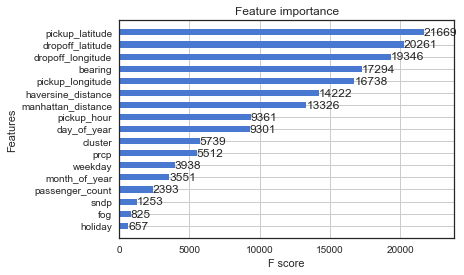

In [49]:
xgb.plot_importance(model, max_num_features=28, height=0.5)

#### Evaluate model performance

In [50]:
# Make prediction on the training data
y_train_pred = model.predict(dtrain)

# Make predictions on test data
y_test_pred = model.predict(dvalid)

# Evaluate
R2_Train = r2_score(y_train_pred, y_train)
R2_Test = r2_score(y_test_pred, y_test)
RMSE_Train = sqrt(mean_squared_error(y_train, y_train_pred))
RMSE_Test = sqrt(mean_squared_error(y_test, y_test_pred))

metric_names = ['R2','RMSE']
metric_values_train = [R2_Train, RMSE_Train]
metric_values_test = [R2_Test, RMSE_Test]
all_metrics = pd.DataFrame({'metrics':metric_names,
                            'train':metric_values_train,
                            'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
print(all_metrics)


            train      test
metrics                    
R2       0.832432  0.774732
RMSE     0.287732  0.330455


## Prediction

In [51]:
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = round(2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d)),3)
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

def feature_engineer(data):
    start = time.time()
    
    # create distance_in_km
    data['haversine_distance'] = haversine_(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create mahattan dist
    data['manhattan_distance'] = manhattan_distance_pd(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create bearing
    data['bearing'] = bearing_array(data.pickup_latitude,data.pickup_longitude,data.dropoff_latitude,data.dropoff_longitude)

    # create weekday
    data["weekday"] = data['pickup_datetime'].dt.dayofweek

    # create holiday
    us_holidays = holidays.UnitedStates()
    data['holiday'] = data['date_of_year'].apply(lambda x: 1 if x in us_holidays else 0)
    
    # K-means clustering
    location = data.loc[:, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]
    kmeans = KMeans(n_clusters=50, random_state=123, n_init = 10, n_jobs = 4).fit(location)
    data['cluster'] = kmeans.labels_
  
    # create geo hash (clustering the pickup and dropoff spots)
#     pickup = []
    dropoff = []
    for i in range(len(data)):
        dropoff.append(ghh.encode(data.dropoff_longitude.iloc[i], data.dropoff_latitude.iloc[i], precision=5))

    data['dropoff_geo_recode'] = dropoff
    data["dropoff_geo_recode"] = data["dropoff_geo_recode"].astype('category').cat.codes

    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [52]:
# Create a function to be calculating memory usage
def get_usage(obj):
    if isinstance(obj, pd.DataFrame):
        usage = obj.memory_usage(deep=True).sum()
    else:
        usage = obj.memory_usage(deep=True)
    return "{:03.2f} MB".format(usage / (1024**2))

def optimizing(data):
    start = time.time()
        
    # Convert object to int
    obj = data.select_dtypes(include = 'object')
    obj_f32 = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert int64 to int8
    obj = data.select_dtypes(include = 'int64')
    obj_int = obj.apply(pd.to_numeric, downcast='unsigned')

    # Convert float64 to float32
    obj = data.select_dtypes(include = 'float64')
    obj_f = obj.apply(pd.to_numeric, downcast='float')

    # Calculated the memory we reduced by down grade int and float
    print("Original memory usage: ", get_usage(data))
    data[obj_f32.columns] = obj_f32
    data[obj_int.columns] = obj_int
    data[obj_f.columns] = obj_f
    print("After converting int and float memory usage: ", get_usage(data))
    
    end = time.time()
    print("Time taken by above function is {}.".format((end-start)/60))
    
    return(data)

In [53]:
def pre_processing(data, weather):
    data = data.reset_index()
    weather = weather[['day', 'month', 'prcp', 'sndp', 'fog', 'visib', 'mxpsd', 'wdsp','gust']]
    data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
    data['date_of_year'] = pd.to_datetime(data['pickup_datetime'].dt.date)
    data['month_of_year'] = data['pickup_datetime'].dt.month
    data['pickup_hour'] = data['pickup_datetime'].dt.hour
    data['day_of_year'] = data['pickup_datetime'].dt.day
    data = pd.merge(data, weather, how = 'inner', left_on = ['day_of_year','month_of_year'], right_on = ['day','month'])
    data = data.sort_values(by=['index']).reset_index()
    return(data)

#### Loading Testing Data

In [54]:
taxi = pd.read_csv("./APM4990_final_test_data_filtered.csv")
weather_2015 = pd.read_csv("./weather_2015_cleaned.csv")

#### Pre-processing

In [55]:
test = pre_processing(taxi, weather_2015)

#### Feature Engineer

In [56]:
test = feature_engineer(test)

Time taken by above function is 1.9641693313916524.


#### Data Optimiziing

In [57]:
test = optimizing(test)

Original memory usage:  141.65 MB
After converting int and float memory usage:  60.23 MB
Time taken by above function is 0.01288511355717977.


In [58]:
selected_features = ['month_of_year', 'day_of_year', 'pickup_hour', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'cluster',
       'dropoff_latitude', 'passenger_count', 'bearing',  'prcp', 'sndp', 'fog', 'weekday', 'holiday', 'manhattan_distance','haversine_distance','dropoff_geo_recode']

test = test[selected_features]

In [59]:
y_pred_GBDT = np.exp(GBDT.predict(test))

In [60]:
result = pd.DataFrame({'predictions':y_pred_GBDT})

In [61]:
result.to_csv('./result.csv',index = False)